In [1]:
from envs.KS_environment_jax import KSenv
from envs.KS_solver_jax import KS
import jax.numpy as jnp
import jax
from functools import partial
from ddpg_with_enkf_experiment_v3 import initialize_ensemble, draw_initial_condition, get_observation_matrix, ensemble_to_state, forecast, apply_enKF
import numpy as np
import utils.visualizations as vis
import ml_collections
import matplotlib.pyplot as plt

In [5]:
def rel_l2(true, pred):
    return jnp.linalg.norm(true-pred)/jnp.linalg.norm(true)

def get_error(env, model, true_state_arr, true_obs_arr, unfilled_obs_arr, state_ens_arr, wait_steps, observation_starts):
    x = env.ks_solver.x
    x_obs = env.observation_locs
    target = env.target

    full_obs_mat = get_observation_matrix(model.N, model.L, x)
    obs_mat = get_observation_matrix(model.N, model.L, x_obs)
    # fill the observations 
    obs_arr = jnp.copy(true_obs_arr)
    for i in range(len(obs_arr)):
       obs_arr = obs_arr.at[wait_steps*i+observation_starts].set(unfilled_obs_arr[i])

    # get full state from low order model
    state_ens_arr_ = jnp.hstack(
        (state_ens_arr, jnp.conjugate(jnp.flip(state_ens_arr[:, 1:-1], axis=1)))
    )
    full_state_ens_arr = jnp.real(
        jnp.einsum("kjm,ij->kim", state_ens_arr_, full_obs_mat)
    )
    # get the mean
    full_state_mean_arr = jnp.mean(full_state_ens_arr, axis=-1)

    # get fourier coefficients
    true_state_arr_f = jnp.fft.rfft(true_state_arr, axis=1)
    mag_state_arr = 2 / env.N * jnp.abs(true_state_arr_f)
    mag_state_ens_arr = 2 / model.N * jnp.abs(state_ens_arr)
    mag_state_mean_arr = jnp.mean(mag_state_ens_arr, axis=-1)

    # get observations from low order model
    obs_ens_arr = jnp.real(jnp.einsum("kjm,ij->kim", state_ens_arr_, obs_mat))
    # get the mean
    obs_mean_arr = jnp.mean(obs_ens_arr, axis=-1)

    # relative l2 errors
    # magnitudes of Fourier coefficients
    err_mag = rel_l2(mag_state_arr[:,:mag_state_mean_arr.shape[1]], mag_state_mean_arr)
    # full state of u
    err_u = rel_l2(true_state_arr, full_state_mean_arr)
    # observation locations
    err_obs = rel_l2(true_obs_arr, obs_mean_arr)

    return err_mag, err_u, err_obs

def plot_episode(env, model, true_state_arr, true_obs_arr, unfilled_obs_arr, state_ens_arr, wait_steps, observation_starts):
    x = env.ks_solver.x
    x_obs = env.observation_locs
    target = env.target

    full_obs_mat = get_observation_matrix(model.N, model.L, x)
    obs_mat = get_observation_matrix(model.N, model.L, x_obs)
    # fill the observations 
    obs_arr = jnp.copy(true_obs_arr)
    for i in range(len(obs_arr)):
       obs_arr = obs_arr.at[wait_steps*i+observation_starts].set(unfilled_obs_arr[i])

    # get full state from low order model
    state_ens_arr_ = jnp.hstack(
        (state_ens_arr, jnp.conjugate(jnp.flip(state_ens_arr[:, 1:-1], axis=1)))
    )
    full_state_ens_arr = jnp.real(
        jnp.einsum("kjm,ij->kim", state_ens_arr_, full_obs_mat)
    )
    # get the mean
    full_state_mean_arr = jnp.mean(full_state_ens_arr, axis=-1)

    # get fourier coefficients
    true_state_arr_f = jnp.fft.rfft(true_state_arr, axis=1)
    mag_state_arr = 2 / env.N * jnp.abs(true_state_arr_f)
    mag_state_ens_arr = 2 / model.N * jnp.abs(state_ens_arr)
    mag_state_mean_arr = jnp.mean(mag_state_ens_arr, axis=-1)

    # get observations from low order model
    obs_ens_arr = jnp.real(jnp.einsum("kjm,ij->kim", state_ens_arr_, obs_mat))
    # get the mean
    obs_mean_arr = jnp.mean(obs_ens_arr, axis=-1)

    fig = vis.plot_episode(
        x,
        x_obs,
        target,
        true_state_arr,
        full_state_ens_arr,
        full_state_mean_arr,
        mag_state_arr,
        mag_state_ens_arr,
        mag_state_mean_arr,
        true_obs_arr,
        obs_arr,
        obs_ens_arr,
        obs_mean_arr,
    )

    return fig

In [2]:
config = ml_collections.ConfigDict()
config.env = ml_collections.ConfigDict()
config.env.N = 64
config.env.nu = 0.08
config.env.actuator_scale = 0.1
config.env.actuator_loss_weight = 1.0
config.env.burn_in = 1000
config.env.actuator_locs = ((2 * jnp.pi) / 8) * jnp.arange(8)
config.env.sensor_locs = ((2 * jnp.pi) / 8) * jnp.arange(8)
config.env.target = "e0"
config.env.frame_skip = 1

config.seed = 41
config.episode_steps = 5000

config.enKF = ml_collections.ConfigDict()
config.enKF.std_init = 0.2
config.enKF.m = 50
config.enKF.std_obs = 0.2
config.enKF.low_order_N = 64
config.enKF.observation_starts = 100
config.enKF.wait_steps = 10

random_episodes = 1
no_actuation = True

In [ ]:
def run_episode(nu, low_order_N, actuator_locs, config, random_episodes=100, no_actuation=False, which='error'):
    config.env.nu = nu
    config.env.actuator_locs = actuator_locs
    # create environment
    env = KSenv(N=config.env.N,
                nu=config.env.nu,
                actuator_scale=config.env.actuator_scale,
                actuator_locs=config.env.actuator_locs,
                actuator_loss_weight=config.env.actuator_loss_weight,
                burn_in=config.env.burn_in,
                sensor_locs=config.env.sensor_locs,
                target=config.env.target,
                frame_skip=config.env.frame_skip)
    # create low order model
    config.enKF.low_order_N = low_order_N
    model = KS(
        nu=config.env.nu,
        N=config.enKF.low_order_N,
        dt=env.dt,
        actuator_locs=config.env.actuator_locs,
        actuator_scale=config.env.actuator_scale,
    )

    # get the observation matrix that maps state to observations
    obs_mat = get_observation_matrix(model.N, model.L, env.observation_locs)

    # create a action of zeros to pass
    null_action = jnp.zeros(env.action_size)

    # jit the necessary environment functions
    model_initialize_ensemble = partial(
        initialize_ensemble,
        env_N=env.N,
        model_N=model.N,
        model_k=model.k,
        std_init=config.enKF.std_init,
        m=config.enKF.m,
    )
    model_initialize_ensemble = jax.jit(model_initialize_ensemble)
    env_draw_initial_condition = partial(draw_initial_condition,
                                    std_init=config.enKF.std_init,)
    env_draw_initial_condition = jax.jit(env_draw_initial_condition)

    env_reset = partial(
        KSenv.reset,
        N=env.N,
        B=env.ks_solver.B,
        lin=env.ks_solver.lin,
        ik=env.ks_solver.ik,
        dt=env.ks_solver.dt,
        initial_amplitude=env.initial_amplitude,
        action_size=env.action_size,
        burn_in=env.burn_in,
        observation_inds=env.observation_inds,
    )
    env_reset = jax.jit(env_reset)
    env_step = partial(
        KSenv.step,
        frame_skip=env.frame_skip,
        B=env.ks_solver.B,
        lin=env.ks_solver.lin,
        ik=env.ks_solver.ik,
        dt=env.ks_solver.dt,
        target=env.target,
        actuator_loss_weight=env.actuator_loss_weight,
        termination_threshold=env.termination_threshold,
        observation_inds=env.observation_inds,
    )
    env_step = jax.jit(env_step)
    env_sample_action = partial(
        KSenv.sample_continuous_space,
        low=env.action_low,
        high=env.action_high,
        shape=(env.action_size,),
    )
    env_sample_action = jax.jit(env_sample_action)

    model_forecast = partial(
        forecast,
        frame_skip=env.frame_skip,
        B=model.B,
        lin=model.lin,
        ik=model.ik,
        dt=model.dt,
    )
    model_forecast = jax.jit(model_forecast)

    model_apply_enKF = partial(
        apply_enKF,
        m=config.enKF.m,
        k=len(model.k),
        M=obs_mat,
    )
    model_apply_enKF = jax.jit(model_apply_enKF)

    def until_first_observation(true_state, true_obs, state_ens, observation_starts):
        def body_fun(carry, _):
            true_state, true_obs, state_ens = carry
            # advance true environment
            action=null_action
            true_state, true_obs, _, _, _, _ = env_step(
                state=true_state, action=action
            )
            # advance model
            state_ens = model_forecast(state_ens=state_ens, action=action)
            return (true_state, true_obs, state_ens), (true_state, true_obs, state_ens, action)

        (true_state, true_obs, state_ens), (
            true_state_arr,
            true_obs_arr,
            state_ens_arr,
            action_arr
        ) = jax.lax.scan(
            body_fun, (true_state, true_obs, state_ens), jnp.arange(observation_starts)
        )
        return (
            true_state,
            true_obs,
            state_ens,
            true_state_arr,
            true_obs_arr,
            state_ens_arr,
            action_arr
        )

    def null_action_observe_and_forecast(
        true_state,
        true_obs,
        state_ens,
        wait_steps,
        episode_steps,
        key_obs,
    ):
        def forecast_fun(carry, _):
            true_state, true_obs, state_ens = carry
            state = ensemble_to_state(state_ens)

            # get action
            action = null_action

            # get the next observation and reward with this action
            next_true_state, next_true_obs, reward, terminated, _, _ = env_step(
                state=true_state, action=action
            )

            # forecast
            next_state_ens = model_forecast(state_ens=state_ens, action=action)
            next_state = ensemble_to_state(next_state_ens)
            return (
                next_true_state,
                next_true_obs,
                next_state_ens,
            ), (true_state, true_obs, state_ens, action, reward)

        def body_fun(carry, _):
            # observe
            # we got an observation
            # define observation covariance matrix
            true_state, true_obs, state_ens, key_obs = carry
            obs_cov = (
                jnp.diag((config.enKF.std_obs * jnp.ones(len(true_obs))))
                * jnp.max(abs(true_obs), axis=0) ** 2
            )

            # add noise on the observation
            key_obs, key_enKF = jax.random.split(key_obs)
            obs = jax.random.multivariate_normal(
                key_obs, true_obs, obs_cov, method="svd"
            )

            # apply enkf to correct the state estimation
            state_ens = model_apply_enKF(Af=state_ens, d=obs, Cdd=obs_cov, key=key_enKF)
            (true_state, true_obs, state_ens), (
                true_state_arr,
                true_obs_arr,
                state_ens_arr,
                action_arr,
                reward_arr,
            ) = jax.lax.scan(
                forecast_fun,
                (true_state, true_obs, state_ens),
                jnp.arange(wait_steps),
            )
            return (
                true_state,
                true_obs,
                state_ens,
                key_obs,
            ), (true_state_arr, true_obs_arr, obs, state_ens_arr, action_arr, reward_arr)

        n_loops = episode_steps // wait_steps
        (true_state, true_obs, state_ens, key_obs), (
            true_state_arr,
            true_obs_arr,
            obs_arr,
            state_ens_arr,
            action_arr,
            reward_arr,
        ) = jax.lax.scan(
            body_fun,
            (true_state, true_obs, state_ens, key_obs),
            jnp.arange(n_loops),
        )
        return (
            true_state,
            true_obs,
            state_ens,
            key_obs,
            true_state_arr,
            true_obs_arr,
            obs_arr,
            state_ens_arr,
            action_arr,
            reward_arr,
        )

    def random_observe_and_forecast(
        true_state,
        true_obs,
        state_ens,
        wait_steps,
        episode_steps,
        key_obs,
        key_action,
    ):
        def forecast_fun(carry, _):
            true_state, true_obs, state_ens, key_action = carry
            state = ensemble_to_state(state_ens)

            # get action
            key_action, _ = jax.random.split(key_action)
            action = env_sample_action(key=key_action)

            # get the next observation and reward with this action
            next_true_state, next_true_obs, reward, terminated, _, _ = env_step(
                state=true_state, action=action
            )

            # forecast
            next_state_ens = model_forecast(state_ens=state_ens, action=action)
            next_state = ensemble_to_state(next_state_ens)
            return (
                next_true_state,
                next_true_obs,
                next_state_ens,
                key_action,
            ), (true_state, true_obs, state_ens, action, reward)

        def body_fun(carry, _):
            # observe
            # we got an observation
            # define observation covariance matrix
            true_state, true_obs, state_ens, key_obs, key_action = carry
            obs_cov = (
                jnp.diag((config.enKF.std_obs * jnp.ones(len(true_obs))))
                * jnp.max(abs(true_obs), axis=0) ** 2
            )

            # add noise on the observation
            key_obs, key_enKF = jax.random.split(key_obs)
            obs = jax.random.multivariate_normal(
                key_obs, true_obs, obs_cov, method="svd"
            )

            # apply enkf to correct the state estimation
            state_ens = model_apply_enKF(Af=state_ens, d=obs, Cdd=obs_cov, key=key_enKF)
            (true_state, true_obs, state_ens, key_action), (
                true_state_arr,
                true_obs_arr,
                state_ens_arr,
                action_arr,
                reward_arr,
            ) = jax.lax.scan(
                forecast_fun,
                (true_state, true_obs, state_ens, key_action),
                jnp.arange(wait_steps),
            )
            return (
                true_state,
                true_obs,
                state_ens,
                key_obs,
                key_action,
            ), (true_state_arr, true_obs_arr, obs, state_ens_arr, action_arr, reward_arr)

        n_loops = episode_steps // wait_steps
        (true_state, true_obs, state_ens, key_obs, key_action), (
            true_state_arr,
            true_obs_arr,
            obs_arr,
            state_ens_arr,
            action_arr,
            reward_arr,
        ) = jax.lax.scan(
            body_fun,
            (true_state, true_obs, state_ens, key_obs, key_action),
            jnp.arange(n_loops),
        )
        return (
            true_state,
            true_obs,
            state_ens,
            key_obs,
            key_action,
            true_state_arr,
            true_obs_arr,
            obs_arr,
            state_ens_arr,
            action_arr,
            reward_arr,
        )

    until_first_observation = partial(
        until_first_observation, observation_starts=config.enKF.observation_starts
    )
    until_first_observation = jax.jit(until_first_observation)

    null_action_observe_and_forecast = partial(
                null_action_observe_and_forecast,
                wait_steps=config.enKF.wait_steps,
                episode_steps=config.episode_steps - config.enKF.observation_starts,
            )
    null_action_observe_and_forecast = jax.jit(null_action_observe_and_forecast )

    random_observe_and_forecast = partial(
        random_observe_and_forecast,
        wait_steps=config.enKF.wait_steps,
        episode_steps=config.episode_steps - config.enKF.observation_starts,
    )
    random_observe_and_forecast = jax.jit(random_observe_and_forecast)

    def episode(key_env, key_obs, key_action):
        # reset the environment
        key_env, key_ens, key_init = jax.random.split(key_env, 3)
        init_true_state_mean, _, _ = env_reset(key=key_env)
        init_true_state = env_draw_initial_condition(u0=init_true_state_mean, key=key_init)
        init_true_obs = init_true_state[env.observation_inds]

        # initialize enKF
        init_state_ens = model_initialize_ensemble(u0=init_true_state_mean, key=key_ens)

        # forecast until first observation
        (
            true_state,
            true_obs,
            state_ens,
            true_state_arr0,
            true_obs_arr0,
            state_ens_arr0,
            action_arr0
        ) = until_first_observation(
            true_state=init_true_state, true_obs=init_true_obs, state_ens=init_state_ens
        )
        if no_actuation:
            (
            true_state,
            true_obs,
            state_ens,
            key_obs,
            true_state_arr,
            true_obs_arr,
            obs_arr,
            state_ens_arr,
            action_arr,
            reward_arr,
            ) = null_action_observe_and_forecast(
                true_state=true_state,
                true_obs=true_obs,
                state_ens=state_ens,
                key_obs=key_obs,
            ) 
        else:
            (
                true_state,
                true_obs,
                state_ens,
                key_obs,
                key_action,
                true_state_arr,
                true_obs_arr,
                obs_arr,
                state_ens_arr,
                action_arr,
                reward_arr,
            ) = random_observe_and_forecast(
                true_state=true_state,
                true_obs=true_obs,
                state_ens=state_ens,
                key_obs=key_obs,
                key_action=key_action,
            )

        true_state_arr = jnp.reshape(
            true_state_arr,
            (
                true_state_arr.shape[0] * true_state_arr.shape[1],
                true_state_arr.shape[2],
            ),
        )
        true_obs_arr = jnp.reshape(
            true_obs_arr,
            (true_obs_arr.shape[0] * true_obs_arr.shape[1], true_obs_arr.shape[2]),
        )
        state_ens_arr = jnp.reshape(
            state_ens_arr,
            (
                state_ens_arr.shape[0] * state_ens_arr.shape[1],
                state_ens_arr.shape[2],
                state_ens_arr.shape[3],
            ),
        )
        action_arr = jnp.reshape(
            action_arr,
            (action_arr.shape[0] * action_arr.shape[1], action_arr.shape[2]),
        )
        reward_arr = jnp.reshape(
            reward_arr,
            (reward_arr.shape[0] * reward_arr.shape[1],),
        )

        stack = lambda a, b, c: jnp.vstack((jnp.expand_dims(a, axis=0), b, c))

        return (
            stack(init_true_state, true_state_arr0, true_state_arr),
            stack(init_true_obs, true_obs_arr0, true_obs_arr),
            obs_arr,
            stack(init_state_ens, state_ens_arr0, state_ens_arr),
            stack(null_action, action_arr0, action_arr),
            reward_arr,
            key_env,
            key_obs,
            key_action,
        )
    
    # random seed for initialization
    key = jax.random.PRNGKey(config.seed)
    key_env, key_obs, key_action = jax.random.split(key, 3) 
    # key, key_network, key_buffer, key_env, key_obs, key_action = jax.random.split(
    #     key, 6
    # )
    # # Initialize errors storage
    # err_mag_arr = jnp.zeros(random_episodes)
    # err_u_arr = jnp.zeros(random_episodes)
    # err_obs_arr = jnp.zeros(random_episodes)
    
    # for eps_idx in range(random_episodes):
    #     (
    #         true_state_arr,
    #         true_obs_arr,
    #         obs_arr,
    #         state_ens_arr,
    #         action_arr,
    #         reward_arr,
    #         key_env,
    #         key_obs,
    #         key_action,
    #     ) = episode(key_env, key_obs, key_action)
    #     err_mag, err_u, err_obs, fig = get_error(env, model, true_state_arr, true_obs_arr, obs_arr, state_ens_arr, config.enKF.wait_steps, config.enKF.observation_starts, plot)
    #     # Store errors
    #     err_mag_arr = err_mag_arr.at[eps_idx].set(err_mag)
    #     err_u_arr = err_u_arr.at[eps_idx].set(err_u)
    #     err_obs_arr = err_obs_arr.at[eps_idx].set(err_obs)

    # return err_mag_arr, err_u_arr, err_obs_arr, fig
    if which == 'error':
        def get_episode_error(key_env, key_obs, key_action):
            (
                true_state_arr,
                true_obs_arr,
                obs_arr,
                state_ens_arr,
                action_arr,
                reward_arr,
                key_env,
                key_obs,
                key_action,
            ) = episode(key_env, key_obs, key_action)
            err_mag, err_u, err_obs = get_error(env, model, true_state_arr, true_obs_arr, obs_arr, state_ens_arr, config.enKF.wait_steps, config.enKF.observation_starts)
            return err_mag, err_u, err_obs
        
        # Generate a batch of random keys for each parallel episode
        keys_env_batch = jax.random.split(key_env, random_episodes)
        keys_obs_batch = jax.random.split(key_obs, random_episodes)
        keys_action_batch = jax.random.split(key_action, random_episodes)
        
        # Vectorized episode function with jax.vmap
        # vmap_episode = jax.vmap(episode, in_axes=(0, 0, 0))
        vmap_episode_error = jax.vmap(get_episode_error, in_axes=(0, 0, 0))
        # Run episodes in parallel
        # episode_results = vmap_episode(keys_env_batch, keys_obs_batch, keys_action_batch)
        error_results = vmap_episode_error(keys_env_batch, keys_obs_batch, keys_action_batch)
        return error_results
    elif which == 'plot':
        figs = []
        for _ in range(random_episodes):
            (
                true_state_arr,
                true_obs_arr,
                obs_arr,
                state_ens_arr,
                action_arr,
                reward_arr,
                key_env,
                key_obs,
                key_action,
            ) = episode(key_env, key_obs, key_action)
            # fig = plot_episode(env, model, true_state_arr, true_obs_arr, obs_arr, state_ens_arr, config.enKF.wait_steps, config.enKF.observation_starts)
            # figs.append(fig)
        return figs            

In [7]:
nu = 0.08
low_order_N = 64
# actuator_locs =  jnp.array([jnp.pi])
actuator_locs =  ((2 * jnp.pi) / 8) * jnp.arange(8)
fig = run_episode(nu, low_order_N, actuator_locs, config, random_episodes=1, no_actuation=True, which='plot')

TypeError: plot_episode() missing 3 required positional arguments: 'obs_mean_arr', 'action_arr', and 'reward_arr'

In [20]:
nu = 0.08
random_episodes = 10
low_order_N_list = [16,18,20,22,24,26,28,30,32,34,36,40]

actuator_locs =  jnp.array([jnp.pi])
# NO ACTUATION
# Initialize lists to store error metrics for each low_order_N
errors_mag_list_no = []  # Magnitude errors
errors_u_list_no = []    # State errors
errors_obs_list_no = []  # Observation errors
for low_order_N in low_order_N_list:
    err_mag, err_u, err_obs = run_episode(nu, low_order_N, actuator_locs, config, random_episodes=random_episodes, no_actuation=True)
    # Append the error values to their respective lists
    errors_mag_list_no.append(err_mag)  # You can store the mean, or raw values
    errors_u_list_no.append(err_u)
    errors_obs_list_no.append(err_obs)
print('Done no actuation')

# NUMBER OF ACTUATORS 1
# Initialize lists to store error metrics for each low_order_N
errors_mag_list_1 = []  # Magnitude errors
errors_u_list_1 = []    # State errors
errors_obs_list_1 = []  # Observation errors
for low_order_N in low_order_N_list:
    err_mag, err_u, err_obs = run_episode(nu, low_order_N, actuator_locs, config, random_episodes=random_episodes, no_actuation=False)
    # Append the error values to their respective lists
    errors_mag_list_1.append(err_mag)  # You can store the mean, or raw values
    errors_u_list_1.append(err_u)
    errors_obs_list_1.append(err_obs)
print('Done 1 actuator')

# NUMBER OF ACTUATORS 2
actuator_locs =  ((2 * jnp.pi) / 2) * jnp.arange(2)
# Initialize lists to store error metrics for each low_order_N
errors_mag_list_2 = []  # Magnitude errors
errors_u_list_2 = []    # State errors
errors_obs_list_2 = []  # Observation errors
for low_order_N in low_order_N_list:
    err_mag, err_u, err_obs = run_episode(nu, low_order_N, actuator_locs, config, random_episodes=random_episodes, no_actuation=False)
    # Append the error values to their respective lists
    errors_mag_list_2.append(err_mag)  # You can store the mean, or raw values
    errors_u_list_2.append(err_u)
    errors_obs_list_2.append(err_obs)
print('Done 2 actuators')

# NUMBER OF ACTUATORS 4
actuator_locs =  ((2 * jnp.pi) / 4) * jnp.arange(4)
# Initialize lists to store error metrics for each low_order_N
errors_mag_list_4 = []  # Magnitude errors
errors_u_list_4 = []    # State errors
errors_obs_list_4 = []  # Observation errors
for low_order_N in low_order_N_list:
    err_mag, err_u, err_obs = run_episode(nu, low_order_N, actuator_locs, config, random_episodes=random_episodes, no_actuation=False)
    # Append the error values to their respective lists
    errors_mag_list_4.append(err_mag)  # You can store the mean, or raw values
    errors_u_list_4.append(err_u)
    errors_obs_list_4.append(err_obs)
print('Done 4 actuators')

# # NUMBER OF ACTUATORS 6
# actuator_locs =  ((2 * jnp.pi) / 6) * jnp.arange(6)
# # Initialize lists to store error metrics for each low_order_N
# errors_mag_list_6 = []  # Magnitude errors
# errors_u_list_6 = []    # State errors
# errors_obs_list_6 = []  # Observation errors
# for low_order_N in low_order_N_list:
#     err_mag, err_u, err_obs = run_episode(nu, low_order_N, actuator_locs, config, random_episodes=random_episodes, no_actuation=False)
#     # Append the error values to their respective lists
#     errors_mag_list_6.append(err_mag)  # You can store the mean, or raw values
#     errors_u_list_6.append(err_u)
#     errors_obs_list_6.append(err_obs)
# print('Done 6 actuators')

# NUMBER OF ACTUATORS 8
actuator_locs =  ((2 * jnp.pi) / 8) * jnp.arange(8)
# Initialize lists to store error metrics for each low_order_N
errors_mag_list_8 = []  # Magnitude errors
errors_u_list_8 = []    # State errors
errors_obs_list_8 = []  # Observation errors
for low_order_N in low_order_N_list:
    err_mag, err_u, err_obs = run_episode(nu, low_order_N, actuator_locs, config, random_episodes=random_episodes, no_actuation=False)
    # Append the error values to their respective lists
    errors_mag_list_8.append(err_mag)  # You can store the mean, or raw values
    errors_u_list_8.append(err_u)
    errors_obs_list_8.append(err_obs)
print('Done 8 actuators')

Done no actuation
Done 1 actuator
Done 2 actuators
Done 4 actuators
Done 8 actuators


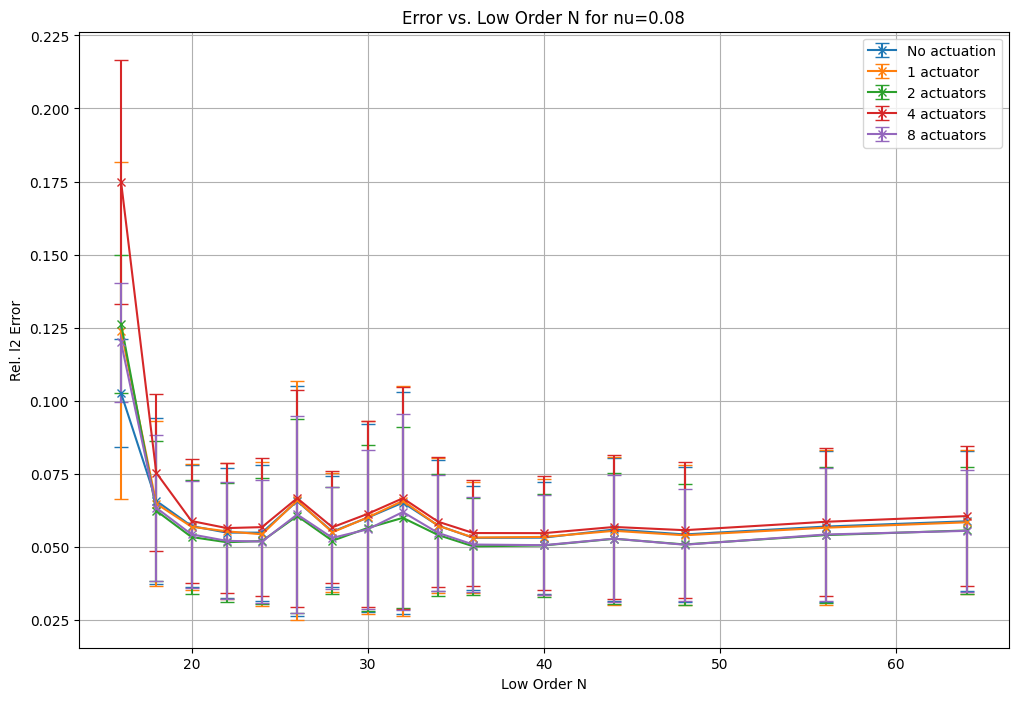

In [19]:
# Plot the errors with respect to low_order_N
plt.figure(figsize=(12, 8))

# Plot magnitude error
labels = ['No actuation','1 actuator','2 actuators','4 actuators','8 actuators']
errors_u_list_list = [errors_u_list_no,errors_u_list_1, errors_u_list_2, errors_u_list_4, errors_u_list_8]
for errors_u_list, label in zip(errors_u_list_list, labels):
    errors_u = np.array(errors_u_list)
    mean_u = np.mean(errors_u, axis=1)
    std_u = np.std(errors_u, axis=1)
    # Plot state error with error bars
    plt.errorbar(low_order_N_list, mean_u, yerr=std_u, label=label, marker="x", capsize=5)

# Label the plot
plt.xlabel("Low Order N")
plt.ylabel("Rel. l2 Error")
plt.title(f"Error vs. Low Order N for nu={nu}")
plt.legend()

# Show the plot
plt.grid(True)
# plt.ylim([0,0.2])
# plt.yscale('log')
plt.show()

In [10]:
# create low order model
env = KSenv(N=config.env.N,
            nu=config.env.nu,
            actuator_scale=config.env.actuator_scale,
            actuator_locs=config.env.actuator_locs,
            actuator_loss_weight=config.env.actuator_loss_weight,
            burn_in=config.env.burn_in,
            sensor_locs=config.env.sensor_locs,
            target=config.env.target,
            frame_skip=config.env.frame_skip)
env_sample_action = partial(
        KSenv.sample_continuous_space,
        low=env.action_low,
        high=env.action_high,
        shape=(env.action_size,),
    )

low_order_N = 20
model = KS(
    nu=config.env.nu,
    N=low_order_N,
    dt=0.05,
    actuator_locs=config.env.actuator_locs,
    actuator_scale=config.env.actuator_scale,
)
key = jax.random.PRNGKey(config.seed)
action = env_sample_action(key=key)
# Calculate the forcing term in real space
f0_env = env.ks_solver.B  @ action
# Transform the forcing term to Fourier space
f_env = jnp.fft.rfft(f0_env, axis=-1)

# Calculate the forcing term in real space
f0_model = model.B  @ action
# Transform the forcing term to Fourier space
f_model = jnp.fft.rfft(f0_model, axis=-1)
f_model2 =  model.N / model.N_fine * f_model[: len(model.k)]

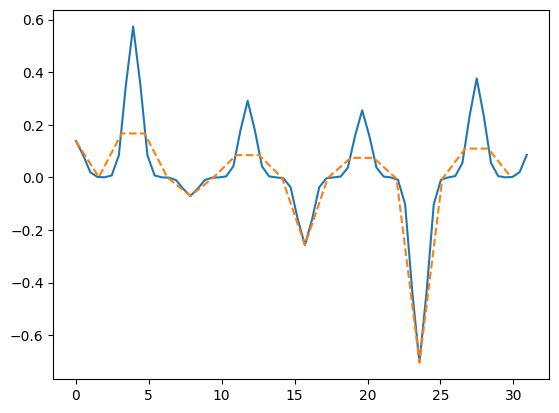

In [23]:
plt.plot(env.ks_solver.x,f0_env)
plt.plot(model.x,f0_model,'--')

In [19]:
from envs.KS_environment import KSenv
from envs.KS_solver import KS
actuator_locs =  ((2 * np.pi) / 8) * jnp.arange(8)
# actuator_locs = np.array([np.pi])
# create low order model
config.env.nu = 0.08
env = KSenv(N=512,
            nu=config.env.nu,
            actuator_scale=config.env.actuator_scale,
            actuator_locs=actuator_locs,
            actuator_loss_weight=config.env.actuator_loss_weight,
            burn_in=config.env.burn_in,
            sensor_locs=config.env.sensor_locs,
            target=config.env.target,
            frame_skip=config.env.frame_skip)

low_order_N = 64
model = KS(
    nu=config.env.nu,
    N=low_order_N,
    dt=0.05,
    actuator_locs=actuator_locs,
    actuator_scale=config.env.actuator_scale,
)

low_order_N = 20
model2 = KS(
    nu=config.env.nu,
    N=low_order_N,
    dt=0.05,
    actuator_locs=actuator_locs,
    actuator_scale=config.env.actuator_scale,
)

action = env.action_space.sample()
# Calculate the forcing term in real space
f0_env = env.KS.B  @ action
# Transform the forcing term to Fourier space
f_env = np.fft.rfft(f0_env, axis=-1)

# Calculate the forcing term in real space
f0_model = model.B  @ action
# Transform the forcing term to Fourier space
f_model = np.fft.rfft(f0_model, axis=-1)
f_model_ =  model.n / model.n_fine * f_model[: len(model.k)]

# Calculate the forcing term in real space
f0_model2 = model2.B  @ action
# Transform the forcing term to Fourier space
f_model2 = np.fft.rfft(f0_model2, axis=-1)
f_model2_ =  model2.n / model2.n_fine * f_model2[: len(model2.k)]

Text(0, 0.5, 'excitation f')

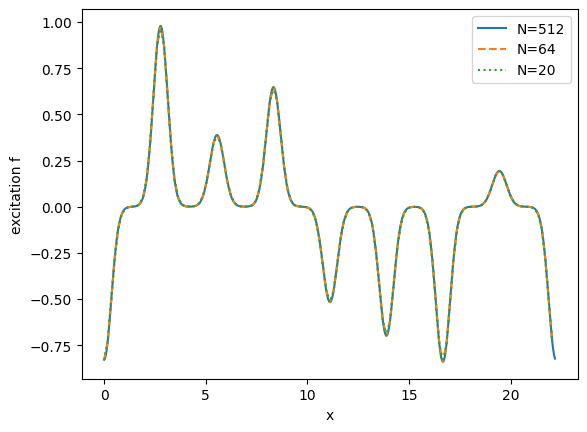

In [20]:
n_fine = max(128, model.n)
x_fine = np.arange(n_fine) * model.L / model.n_fine
plt.plot(env.KS.x,f0_env,'-', label=f'N={env.N}')
plt.plot(x_fine,f0_model,'--', label=f'N={model.n}')
plt.plot(x_fine,f0_model2,':', label=f'N={model2.n}')
plt.legend()
# plt.xlim([0,5])
plt.xlabel('x')
plt.ylabel('excitation f')

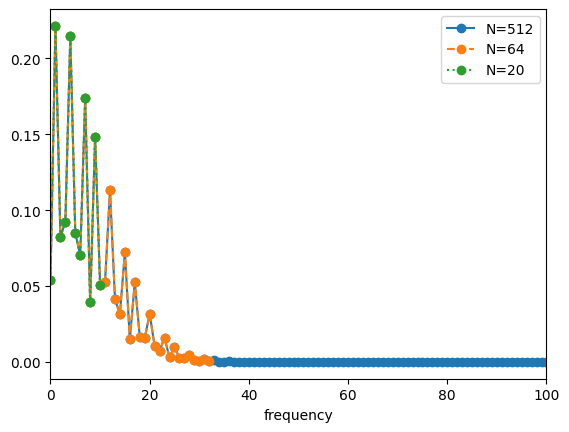

In [21]:
plt.plot(2*np.abs(f_env)/env.N,'-o', label=f'N={env.N}')
plt.plot(2*np.abs(f_model_)/model.n,'--o', label=f'N={model.n}')
plt.plot(2*np.abs(f_model2_)/model2.n,':o', label=f'N={model2.n}')
plt.xlim([0,100])
plt.xlabel('frequency')
plt.legend()

In [145]:
from scipy.stats import norm
def normal_pdf(x, loc, scale):
    return norm.pdf(x, loc, scale)

In [146]:
env.actuator_locs

Array([0.        , 0.78539816, 1.57079633, 2.35619449, 3.14159265,
       3.92699082, 4.71238898, 5.49778714], dtype=float64, weak_type=True)

In [147]:
action

array([-0.21634771, -0.27454913,  0.78100085,  0.6709911 , -0.68347144,
       -0.9033899 ,  0.21245301,  0.12030204], dtype=float32)

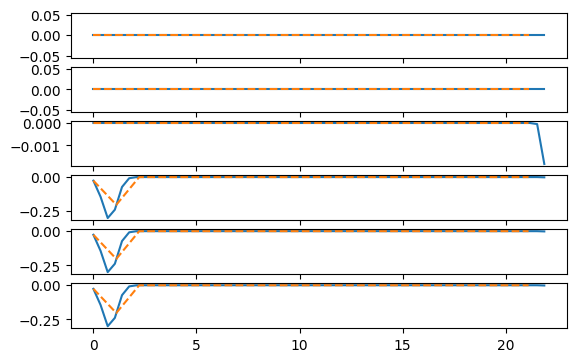

In [149]:
y = np.zeros(env.KS.x.shape)
idx = 1
for k, shift in enumerate(range(-3, 3)):
    y += normal_pdf(env.KS.x + shift * env.KS.L, env.actuator_locs[idx], env.KS.scale)
    plt.subplot(7,1,k+1)
    plt.plot(env.KS.x, y * action[idx])
y = y / np.max(y)

y = np.zeros(model.x.shape)
for k, shift in enumerate(range(-3, 3)):
    y += normal_pdf(model.x + shift * model.L, env.actuator_locs[idx], model.scale)
    plt.subplot(7,1,k+1)
    plt.plot(model.x, y * action[idx],'--')
y = y / np.max(y)